In [1]:
"""Generate 100 Gaussian mocks based on based on $C_l$s from CCL."""

'Generate 100 Gaussian mocks based on based on $C_l$s from CCL.'

In [1]:
import numpy as np
import pandas as pd
import healpy as hp
from astropy.io import fits
import matplotlib.pyplot as plt
plt.style.use("seaborn-notebook")
import pyccl as ccl

from tqdm import tqdm #for timing

from IPython.display import HTML
from IPython.display import display

In [2]:
#For binning data
def bin_mat(r=[],mat=[],r_bins=[]):#works for cov and skewness
    bin_center=0.5*(r_bins[1:]+r_bins[:-1])
    n_bins=len(bin_center)
    ndim=len(mat.shape)
    mat_int=np.zeros([n_bins]*ndim,dtype='float64')
    norm_int=np.zeros([n_bins]*ndim,dtype='float64')
    bin_idx=np.digitize(r,r_bins)-1
    r2=np.sort(np.unique(np.append(r,r_bins))) #this takes care of problems around bin edges
    dr=np.gradient(r2)
    r2_idx=[i for i in np.arange(len(r2)) if r2[i] in r]
    dr=dr[r2_idx]
    r_dr=r*dr

    ls=['i','j','k','l']
    s1=ls[0]
    s2=ls[0]
    r_dr_m=r_dr
    for i in np.arange(ndim-1):
        s1=s2+','+ls[i+1]
        s2+=ls[i+1]
        r_dr_m=np.einsum(s1+'->'+s2,r_dr_m,r_dr)#works ok for 2-d case

    mat_r_dr=mat*r_dr_m
    for indxs in itertools.product(np.arange(min(bin_idx),n_bins),repeat=ndim):
        x={}#np.zeros_like(mat_r_dr,dtype='bool')
        norm_ijk=1
        mat_t=[]
        for nd in np.arange(ndim):
            slc = [slice(None)] * (ndim)
            #x[nd]=bin_idx==indxs[nd]
            slc[nd]=bin_idx==indxs[nd]
            if nd==0:
                mat_t=mat_r_dr[slc]
            else:
                mat_t=mat_t[slc]
            norm_ijk*=np.sum(r_dr[slc[nd]])
        if norm_ijk==0:
            continue
        mat_int[indxs]=np.sum(mat_t)/norm_ijk
        norm_int[indxs]=norm_ijk
    return bin_center,mat_int

# 1: Generate $C^{gg}_{L}$ from `CCL`

Text(0, 0.5, 'dn')

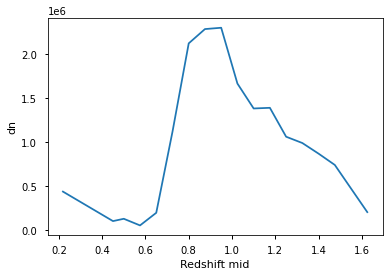

In [3]:
#define cosmology
cosmo = ccl.Cosmology(Omega_c = 0.27, Omega_b = 0.045, h = 0.67, sigma8 = 0.83, n_s = 0.96)
lmin = 100; lmax = 1024
ell = np.arange(0, lmax, 1); fs = 20

#read in dNdz
dNdzddeg2 = pd.read_csv("../dat/nz_blanc.txt", sep=",")
zmid = dNdzddeg2['Redshift_mid']
dndz = dNdzddeg2['dndz/deg^2'] * 14000
dn = dndz[:-1] * np.diff(zmid)  #redshift bin width

plt.plot(zmid[:-1], dn)
plt.xlabel("Redshift mid")
plt.ylabel("dn")

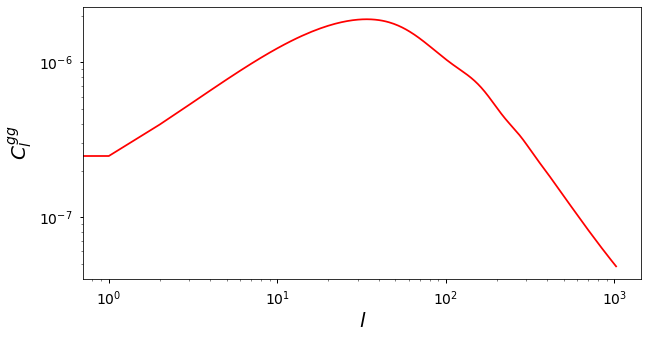

In [4]:
#set constant bias
b = 1.2*np.ones(len(zmid[:-1]))

#Create CCL tracer object for galaxy clustering
elg_ccl = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(zmid[:-1], dn), bias=(zmid[:-1],b))

#calculate theoretical Cls
cls_elg_th = ccl.angular_cl(cosmo, elg_ccl, elg_ccl, ell)

plt.figure(figsize = (10, 5))
plt.xlabel('$l$',fontsize=fs)
plt.ylabel('$C^{g g}_{l}$',fontsize=fs)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.xscale('log')
plt.plot(ell, cls_elg_th, 'r-')

# 2: Generate a realization and noise map

## Realization

/home/tanveer/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:907: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/home/tanveer/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:908: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/home/tanveer/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:909: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to mod

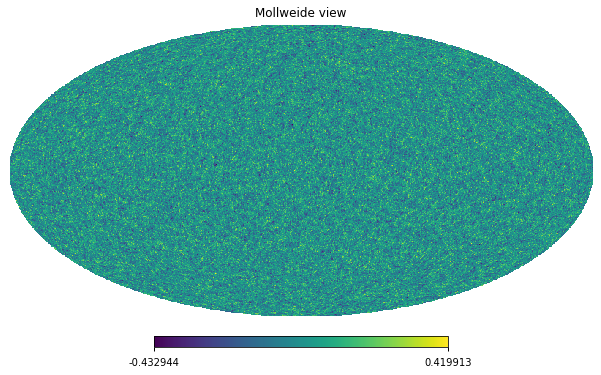

In [5]:
NSIDE = 256
delta_g = hp.synfast(cls_elg_th, nside = NSIDE, pol=False, verbose=False)
hp.mollview(delta_g)

## Noise Map

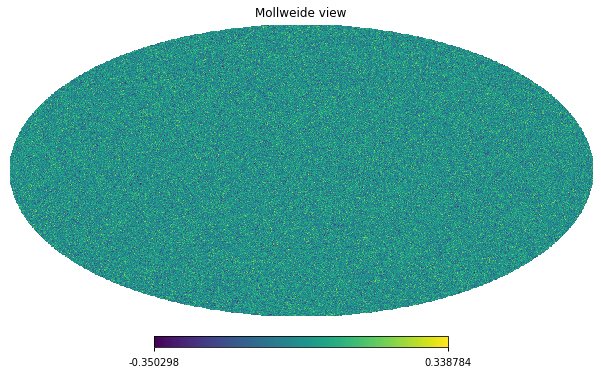

In [6]:
nbar = 2400 #per deg2
nbar = 2400 * (1/(4*np.pi**2/(129600))) #conversion factor from sq deg to sr. 1 deg2 = 4pi^2/129600 sr
cl_shot_noise = 1/nbar * np.ones_like(ell)
noise_g = hp.synfast(cl_shot_noise, nside = NSIDE, pol = False, verbose = False)
hp.mollview(noise_g)

# Import Mehdi's neural network weight map

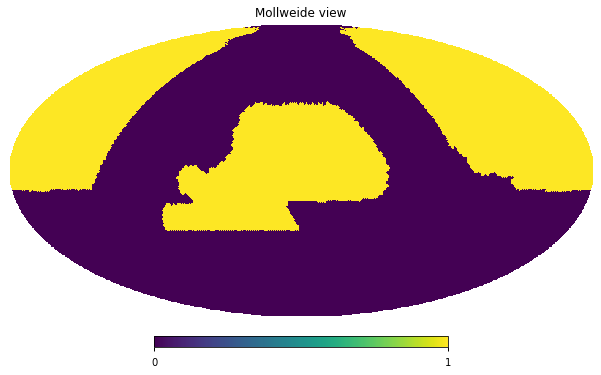

In [7]:
#read in random and degrade it to generate mask
dr_elg_ran = np.load("../dat/elg_ran1024.npy")
dr_elg_ran64 = hp.ud_grade(dr_elg_ran, 64) #make it very coarse to remove weird effects in the middle
dr_elg_ran_final = hp.ud_grade(dr_elg_ran64, NSIDE)

mask = np.copy(dr_elg_ran_final)
mask[dr_elg_ran_final != 0] = 1 #good pixels are 1
mask = mask.astype("bool")
hp.mollview(mask)

In [8]:
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '../src/')
from lib import GenSys

gs = GenSys('../dat/nn-weights-combined.fits')          # window functions

#--- contaminate a given density field
delta_c = gs.contaminate(0, delta_g, mask, noise=False)

# of selection functions:  (302503, 125)


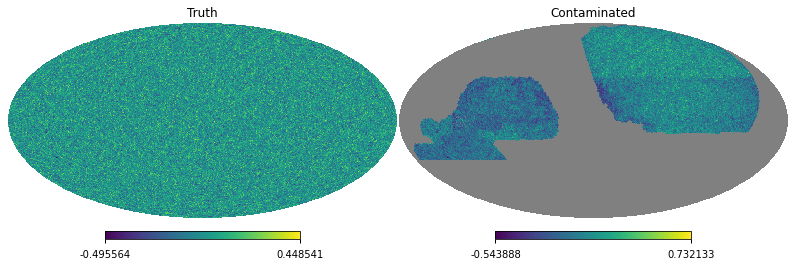

In [9]:
fg, ax = plt.subplots(ncols=2, figsize=(14, 4.5))
fg.subplots_adjust(wspace=0.0)

for i, (map_i, title_i) in enumerate(zip([delta_g, delta_c],
                                         ['Truth', 'Contaminated'])):
    plt.sca(ax[i])
    hp.mollview(map_i, rot=-85, hold=True, title=title_i)

# Test with $100$ Gaussian realizations

## Generate mocks

In [13]:
NMOCKS = 100
delta_g = np.zeros((NMOCKS, 12 * NSIDE**2))

In [14]:
SEED = 67
for i in tqdm(range(NMOCKS)):
    np.random.seed(SEED + i**2)
    delta_g[i] = hp.synfast(cls_elg_th, nside = NSIDE, pol=False, verbose=False)

100%|██████████| 100/100 [00:02<00:00, 33.87it/s]


## Apply mask to mocks

In [15]:
delta_c = np.zeros((NMOCKS, 12 * NSIDE**2))

for i in tqdm(range(NMOCKS)):
    delta_c[i] = gs.contaminate(0, delta_g[i], mask, noise=True)

100%|██████████| 100/100 [00:04<00:00, 23.73it/s]


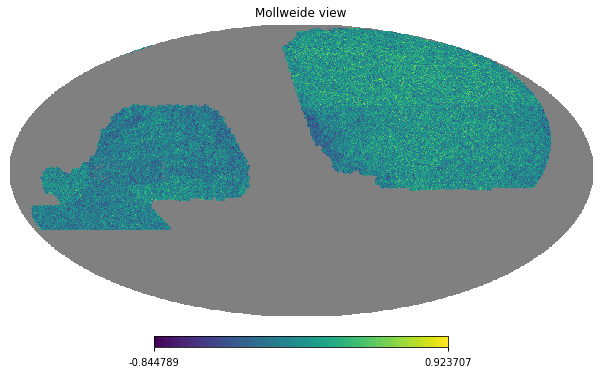

In [16]:
#view one map
hp.mollview(delta_c[0], rot=-85)

## Calculate $\tilde{C_{l}^{gg}}$ for all maps

In [20]:
cls_obs = np.zeros((NMOCKS, lmax))

for i in tqdm(range(NMOCKS)):
    cls_obs[i] = hp.anafast(delta_c[i], lmax = lmax -1)

100%|██████████| 100/100 [00:12<00:00,  8.23it/s]


In [52]:
tmpcl = hp.anafast(delta_g[0], lmax = lmax - 1)

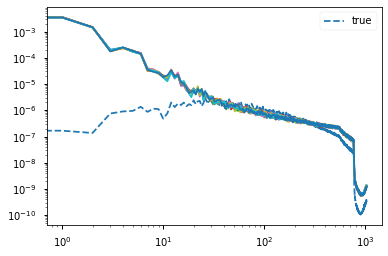

In [55]:
plt.loglog(ell, tmpcl, label = 'true', ls = '--')
for i in range(10):
    plt.loglog(ell, cls_obs[i])
    
plt.legend(loc = 'best')

In [34]:
#calculate covariance matrix
covmat = np.cov(cls_obs.T)

<AxesSubplot:>

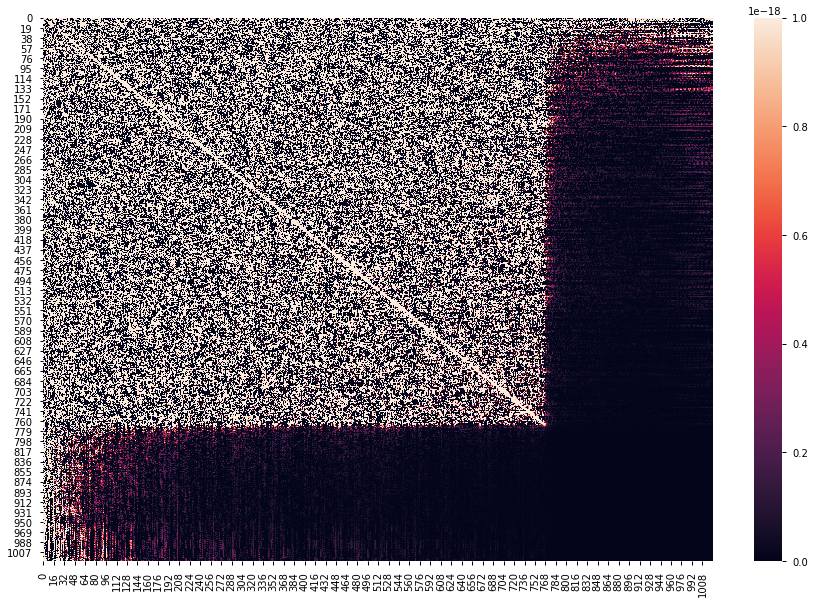

In [51]:
#visualize covariance matrix
import seaborn as sns
plt.figure(figsize = (15, 10))
sns.heatmap(covmat, vmin = 0, vmax = 1e-18)